# Exercício em Python - Tema 10 - Estimativa de Vazões a partir da Precipitação e Temperatura

Este exercício tem por objetivo prever vazões em bacias hidrográficas a partir da base de dados do CABra, que contém 735 bacias hidrográficas com os valores de temperatura e precipitações diários de outubro de 1980 a setembro de 2010 (30 anos hidrológicos). Para quantificar tais vazões pelo método, são usados dados de precipitação e temperatura médias das bacias, contidas na própria base de dados do CABra.

Vamos aqui aplicar o método de Grunsky para a Bacia 1. A análise passa pelas escalas anual e mensal, comparando-se os valores previstos com os observados.

##1. Importação de bibliotecas.



In [47]:
import pathlib
import pandas as pd
import numpy as np
import io
import requests
from sklearn.linear_model import LinearRegression # Cálculo de uma equação de regressão
import matplotlib.pyplot as plt #Plotagem dos dados
import scipy # Biblioteca para calculos estatisticos da comparação das séries

##2. Importação dos dados do CABra

In [2]:
#Escolha da bacia e base de dados (no caso, "ensemble")
bacia1 = "1"
base1 = "ens"
base2 = "ENS"

url = ("https://raw.githubusercontent.com/brunokenmarchezepe/CABra_exercicios/main/CABRA_dataset/CABra_climate_daily_series/" + base1 + "/CABra_" + bacia1 + "_climate_" + base2 + ".txt")

bacia_df = requests.get(url).content
bacia_df = pd.read_csv(io.StringIO(bacia_df.decode('utf-8', errors = 'ignore')),
                 skiprows = 13,
                 delimiter='\t')

bacia_df.columns = ['Year', 'Month', 'Day', 'p', 'tmin', 'tmax', 'rh', 'wnd', 'srad', 'et', 'pet_pm','pet_pt', 'pet_hg']

#Importação de dados de vazão observados
url = ("https://raw.githubusercontent.com/brunokenmarchezepe/CABra_exercicios/main/CABRA_dataset/CABra_daily_streamflow" + "/CABra_" + bacia1 + "_streamflow.txt")

bacia_df_streamflow = requests.get(url).content
bacia_df_streamflow = pd.read_csv(io.StringIO(bacia_df_streamflow.decode('utf-8', errors = 'ignore')),
                 skiprows = 8,
                 delimiter='\t')

bacia_df_streamflow.columns = ['Year','Month','Day','q','Quality']

#Unindo as duas bases através das colunas de ano ("Year"), mês ("Month") e dia ("Day")
bacia_df = pd.merge(bacia_df, bacia_df_streamflow, on=['Year','Month','Day'])
bacia_df.head()

,Year,Month,Day,p,tmin,tmax,rh,wnd,srad,et,pet_pm,pet_pt,pet_hg,q,Quality
0,,,,mm,C,C,%,m s,MJ m,mm,mm,mm,mm,(m³s¯¹),
1,1980,10,1,4.669,22.521,31.019,85.222,0.694,17.078,3.777,4.381,5.276,4.199,1165.800,2
2,1980,10,2,11.884,22.645,31.321,82.020,0.760,15.329,4.022,4.040,4.781,3.780,1181.200,2
3,1980,10,3,9.195,22.308,30.400,86.096,0.615,15.450,4.173,3.985,4.791,3.761,1194.400,2
4,1980,10,4,9.348,21.887,30.540,85.902,0.691,15.414,3.898,4.003,4.778,3.745,1201.000,2


In [3]:
#Exclui linha 0 pois não faz parte dos dados
bacia_df = bacia_df.drop([0], axis=0)

#Passando todos os dados para categoria numérica
bacia_df = bacia_df.apply(pd.to_numeric)

In [4]:
#Correções e adequações dos dados

#Cálculo da temperatura média a partir das temperaturas mínima e máxima diária
bacia_df['tmean'] = (bacia_df.tmin + bacia_df.tmax)/2

#Mudança de unidades da coluna de vazão ("q") de m3/s para mm, importando a área da bacia para esta conversão
url = ("https://raw.githubusercontent.com/brunokenmarchezepe/CABra_exercicios/main/CABRA_dataset/CABra_daily_streamflow" + "/CABra_" + bacia1 + "_streamflow.txt")

# Baixa o conteúdo do arquivo
response = requests.get(url)
if response.status_code == 200:
    lines = response.text.split("\n")  # Divide o conteúdo em linhas

    # Pega a quinta linha e extrai o valor numérico da área
    area_line = lines[4]  # Lembre-se que a indexação começa em 0
    area_value = float(area_line.split()[1])  # Converte o segundo elemento para float

bacia_df['q'] = (bacia_df['q'] * 60 * 60 * 24 * 1000) / (area_value * 1000000) #Conversão de m³/s para mm/dia/area, sabendo que a área está em km²

In [5]:
bacia_df.head()

,Year,Month,Day,p,tmin,tmax,rh,wnd,srad,et,pet_pm,pet_pt,pet_hg,q,Quality,tmean
1,1980,10,1,4.669,22.521,31.019,85.222,0.694,17.078,3.777,4.381,5.276,4.199,0.413808,2,26.7700
2,1980,10,2,11.884,22.645,31.321,82.020,0.760,15.329,4.022,4.040,4.781,3.780,0.419274,2,26.9830
3,1980,10,3,9.195,22.308,30.400,86.096,0.615,15.450,4.173,3.985,4.791,3.761,0.423960,2,26.3540
4,1980,10,4,9.348,21.887,30.540,85.902,0.691,15.414,3.898,4.003,4.778,3.745,0.426302,2,26.2135
5,1980,10,5,14.407,19.680,26.941,88.454,1.502,11.080,2.477,3.103,3.475,2.521,0.427083,2,23.3105


###2.1.	Escolha de escala temporal

In [6]:
#Conversão de colunas de data para formato "dtype"
cols=["Year","Month","Day"]
bacia_df['date'] = bacia_df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
bacia_df['date']=pd.to_datetime(bacia_df['date'])

In [7]:
#Caso se deseje, utilizar dados a partir de determinado ano, mês e dia
data_base = '1980-01-01'
bacia_df = bacia_df[bacia_df.date >= data_base]
bacia_df.head()

,Year,Month,Day,p,tmin,tmax,rh,wnd,srad,et,pet_pm,pet_pt,pet_hg,q,Quality,tmean,date
1,1980,10,1,4.669,22.521,31.019,85.222,0.694,17.078,3.777,4.381,5.276,4.199,0.413808,2,26.7700,1980-10-01
2,1980,10,2,11.884,22.645,31.321,82.020,0.760,15.329,4.022,4.040,4.781,3.780,0.419274,2,26.9830,1980-10-02
3,1980,10,3,9.195,22.308,30.400,86.096,0.615,15.450,4.173,3.985,4.791,3.761,0.423960,2,26.3540,1980-10-03
4,1980,10,4,9.348,21.887,30.540,85.902,0.691,15.414,3.898,4.003,4.778,3.745,0.426302,2,26.2135,1980-10-04
5,1980,10,5,14.407,19.680,26.941,88.454,1.502,11.080,2.477,3.103,3.475,2.521,0.427083,2,23.3105,1980-10-05


In [8]:
#Caso se deseje, utilizar ano hidrológico (1/10 a 30/09)
bacia_df['water_year'] = bacia_df.date.dt.year.where(bacia_df.date.dt.month < 10, bacia_df.date.dt.year + 1)
bacia_df.head()

,Year,Month,Day,p,tmin,tmax,rh,wnd,srad,et,pet_pm,pet_pt,pet_hg,q,Quality,tmean,date,water_year
1,1980,10,1,4.669,22.521,31.019,85.222,0.694,17.078,3.777,4.381,5.276,4.199,0.413808,2,26.7700,1980-10-01,1981
2,1980,10,2,11.884,22.645,31.321,82.020,0.760,15.329,4.022,4.040,4.781,3.780,0.419274,2,26.9830,1980-10-02,1981
3,1980,10,3,9.195,22.308,30.400,86.096,0.615,15.450,4.173,3.985,4.791,3.761,0.423960,2,26.3540,1980-10-03,1981
4,1980,10,4,9.348,21.887,30.540,85.902,0.691,15.414,3.898,4.003,4.778,3.745,0.426302,2,26.2135,1980-10-04,1981
5,1980,10,5,14.407,19.680,26.941,88.454,1.502,11.080,2.477,3.103,3.475,2.521,0.427083,2,23.3105,1980-10-05,1981


##3. Análise Interanual / Longo Termo

In [9]:
#Cria func (para remover outliers)
def remove_outliers(df, column_name):
    # Calculate Q1 and Q3
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    df_no_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return df_no_outliers

# Example usage (assuming 'bacia_df' DataFrame is defined)
bacia_df = remove_outliers(bacia_df, 'q') # Replace 'q' with the actual column name if different

bacia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10957 entries, 1 to 10957
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Year        10957 non-null  int64         
 1   Month       10957 non-null  int64         
 2   Day         10957 non-null  int64         
 3   p           10957 non-null  float64       
 4   tmin        10957 non-null  float64       
 5   tmax        10957 non-null  float64       
 6   rh          10957 non-null  float64       
 7   wnd         10957 non-null  float64       
 8   srad        10957 non-null  float64       
 9   et          10957 non-null  float64       
 10  pet_pm      10957 non-null  float64       
 11  pet_pt      10957 non-null  float64       
 12  pet_hg      10957 non-null  float64       
 13  q           10957 non-null  float64       
 14  Quality     10957 non-null  int64         
 15  tmean       10957 non-null  float64       
 16  date        10957 non-

In [10]:
#Soma de dados diários para ter dados anuais
bacia_ano = bacia_df.groupby('Year').agg({'p': 'sum', 'q': 'sum', 'tmean': 'mean'}) #Pode-se escolher 'water_year' para utilizar o ano hidrológico

#Média dos dados anuais, obtendo-se valores de longo termo, ou seja, médias anuais
mean_p = remove_outliers(bacia_ano, 'p').p.mean()
mean_q = remove_outliers(bacia_ano, 'q').q.mean()
mean_t = remove_outliers(bacia_ano, 'tmean').tmean.mean()

###3.1 Cálculo de α

Com os dados

In [11]:
#Calculo de alpha a partir dos dados de temperatura media e precipitação para a bacia

alpha = -1.102E-5 * mean_t + 4.851E-8 * mean_p + 3.819E-4

print("O valor de alpha é: ", alpha)

O valor de alpha é:  0.00019526171931041905


Aplicamos agora a Equação Generalizada de Grunsky com o alpha que calculamos anteriormente

In [12]:
#Definição da função generalizada do Grunsky
def gr(p, alpha):
  if p <= 1/(2*alpha):
    return alpha * (p**2)
  else:
    return p - 1/(4 * alpha)

In [13]:
#Aplicação da função com o mean_p e alpha
q_pred = gr(mean_p, alpha)

#Cálculo do erro em comparação com o mean_q observado na bacia:

erro = (q_pred - mean_q)/mean_q * 100
print("O erro em relação ao valor observado é: ", round(erro, 2), "%, em que",round(q_pred, 2),"é o valor previsto e", round(mean_q, 2), "é o valor observado")

O erro em relação ao valor observado é:  2.49 %, em que 837.98 é o valor previsto e 817.61 é o valor observado


##4. Análise Anual

Vamos agora analisar os valores ano a ano e verificar se, para os valores anuais, a vazão pode ser prevista com uma boa precisão.

In [14]:
#Resgatando os dados anuais, e excluindo outliers
bacia_ano = remove_outliers(bacia_ano, 'p')
bacia_ano.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 1981 to 2009
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   p       29 non-null     float64
 1   q       29 non-null     float64
 2   tmean   29 non-null     float64
dtypes: float64(3)
memory usage: 928.0 bytes


###4.1. Cálculo de α

In [15]:
#Calculo de alpha a partir dos dados de temperatura media e precipitação para cada ano

bacia_ano["alpha"] = -1.102E-5 * bacia_ano["tmean"] + 4.851E-8 * bacia_ano["p"] + 3.819E-4

bacia_ano.head()

,p,q,tmean,alpha
Year,,,,
1981,2109.139,776.374031,25.726196,0.000201
1982,2140.691,907.643525,25.866263,0.000201
1983,1845.893,752.443548,26.150812,0.000183
1984,2225.567,832.025264,25.587354,0.000208
1985,2342.434,876.799857,25.381545,0.000216


In [16]:
#Usando a mesma função de antes, só que agora calculando um q_pred por ano, vamos ver como ficam os resultados:

bacia_ano["q_pred"] = bacia_ano.apply(lambda row: gr(row["p"], row["alpha"]), axis=1)

bacia_ano.head()

,p,q,tmean,alpha,q_pred
Year,,,,,
1981,2109.139,776.374031,25.726196,0.000201,892.859235
1982,2140.691,907.643525,25.866263,0.000201,919.713434
1983,1845.893,752.443548,26.150812,0.000183,624.433537
1984,2225.567,832.025264,25.587354,0.000208,1029.708134
1985,2342.434,876.799857,25.381545,0.000216,1184.098021


###4.2. Plotagem dos Resultados

In [17]:
#Define a função kge()
def kge(q_sim, q_obs):
    r = np.corrcoef(q_sim, q_obs)[0, 1]
    alpha = np.std(q_sim) / np.std(q_obs)
    beta = np.mean(q_sim) / np.mean(q_obs)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

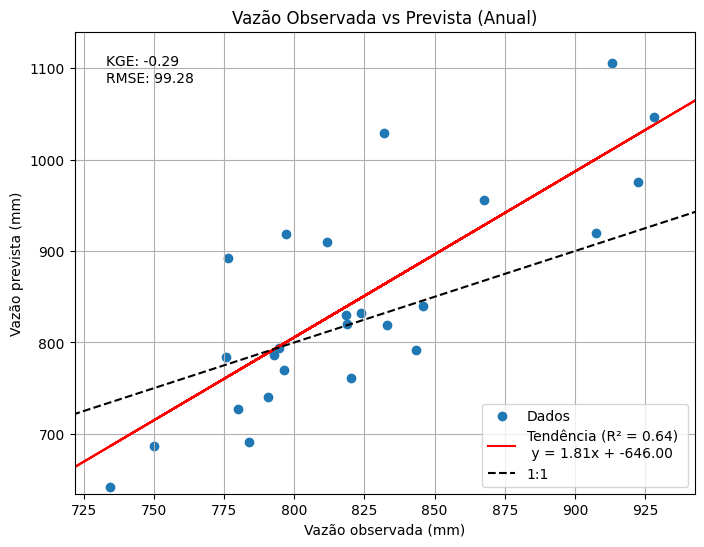

In [44]:
# Excluir outliers
# Exemplo de método: Excluindo valores onde a diferença entre q e q_pred é maior que 2 desvios padrões
# diff = np.abs(bacia_ano['q'] - bacia_ano['q_pred'])
# threshold = np.mean(diff) + 2 * np.std(diff)
# bacia_ano_filtered = bacia_ano[diff <= threshold]
bacia_ano_filtered  = bacia_ano

# Ajustar a linha de tendência
x = bacia_ano_filtered['q'].values.reshape(-1, 1)
y = bacia_ano_filtered['q_pred'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(x, y)

# Previsões da linha de tendência
y_pred = model.predict(x)

# Calcular R²
r2 = r2_score(y, y_pred)

# Calcular KGE e RMSE
kge_result = kge(bacia_ano_filtered['q_pred'], bacia_ano_filtered['q'])
rmse = np.sqrt(np.mean((bacia_ano_filtered['q_pred'] - bacia_ano_filtered['q'])**2))

# Plotagem
plt.figure(figsize=(8, 6))
plt.scatter(bacia_ano_filtered['q'], bacia_ano_filtered['q_pred'], label='Dados')
plt.plot(x, y_pred, color='red', label=f'Tendência (R² = {r2:.2f}) \n y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f}')
plt.plot([0, max(bacia_ano_filtered['q'].max(), bacia_ano_filtered['q_pred'].max())], [0, max(bacia_ano_filtered['q'].max(), bacia_ano_filtered['q_pred'].max())], color='black', linestyle='--', label='1:1')
plt.xlabel('Vazão observada (mm)')
plt.ylabel('Vazão prevista (mm)')
plt.title('Vazão Observada vs Prevista (Anual)')
plt.legend()
plt.grid(True)
# Ajustar limites do gráfico para zoom (excluir valores extremos)
plt.xlim(np.percentile(bacia_ano_filtered['q'], 2), np.percentile(bacia_ano_filtered['q'], 98))
plt.ylim(np.percentile(bacia_ano_filtered['q_pred'], 2), np.percentile(bacia_ano_filtered['q_pred'], 98))

plt.text(0.05, 0.95, f'KGE: {kge_result:.2f}\nRMSE: {rmse:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.show()


##5. Análise Mensal

In [20]:
#Soma de dados diários para ter dados mensais
tipo_ano = 'Year' #Pode-se escolher 'water_year' para utilizar o ano hidrológico
bacia_mes = bacia_df.pivot_table({'p', 'q','tmean'}, [tipo_ano, 'Month'], aggfunc={'p': 'sum', 'q': 'sum', 'tmean': 'mean'}).reset_index()
bacia_mes.head()

,Year,Month,p,q,tmean
0,1980,10,215.458,16.220045,26.364516
1,1980,11,194.502,24.672285,26.146200
2,1980,12,207.923,47.464423,26.545742
3,1981,1,261.773,69.274972,26.229065
4,1981,2,294.824,99.782965,25.832875


###5.1. Cálculo de α

In [21]:
#Removendo outliers
bacia_mes = remove_outliers(bacia_mes, 'p')
bacia_mes = remove_outliers(bacia_mes, 'q')
bacia_mes = remove_outliers(bacia_mes, 'tmean')
bacia_mes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343 entries, 0 to 358
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    343 non-null    int64  
 1   Month   343 non-null    int64  
 2   p       343 non-null    float64
 3   q       343 non-null    float64
 4   tmean   343 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 16.1 KB


In [22]:
#Calculo de média mensal
media_mes = bacia_mes.groupby("Month").mean()

#Calculo de alpha a partir dos dados de temperatura media e precipitação para cada média mensal

A = [-1.55E-04,-1.96E-04,-2.56E-04,-1.43E-04,-2.17E-04,1.03E-04,3.79E-04,-9.27E-05,2.57E-06,-1.11E-04,-1.78E-04,-1.82E-04]
B = [-9.02E-08,-7.43E-07,5.20E-07,-6.76E-06,-1.33E-05,1.11E-04,1.53E-04,-5.11E-06,-3.94E-07,7.22E-06,-2.93E-06,-2.46E-06]
C = [0.005,0.006,0.007,0.007,0.009,-0.015,-0.021,0.006,0.002,0.003,0.006,0.006]

# Criar uma coluna 'alpha' antes do loop
media_mes["alpha"] = np.nan  # Inicializa com os valores NaN

for i in range(12): #Metodo iterativo range(12) para percorrer o calculo do alpha através dos meses
  media_mes.loc[media_mes.index == i + 1, "alpha"] = A[i] * media_mes.loc[media_mes.index == i + 1, "tmean"].values + B[i] * media_mes.loc[media_mes.index == i + 1, "p"].values + C[i]

media_mes

,Year,p,q,tmean,alpha
Month,,,,,
1,1995.500000,279.154600,88.397248,26.259958,0.000905
2,1995.500000,269.734067,107.645041,26.202419,0.000664
3,1995.500000,274.985533,132.591851,26.255298,0.000422
4,1995.500000,206.772733,131.756922,26.045188,0.001878
5,1995.500000,119.315333,127.361069,25.405635,0.001900
6,1996.954545,61.073773,81.920438,25.153225,-0.005630
7,1997.260870,39.696174,33.007643,25.282817,-0.005344
8,1995.500000,57.143200,17.357190,26.104844,0.003288
9,1994.928571,105.764071,13.218117,26.533374,0.002027


In [23]:
#Nome dos meses
meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

media_mes["month_name"] = meses

#Usando a mesma função de antes, só que agora calculando um q_pred por mes, vamos ver como ficam os resultados:

media_mes["q_pred"] = media_mes.apply(lambda row: gr(row["p"], row["alpha"]), axis=1)

media_mes

,Year,p,q,tmean,alpha,month_name,q_pred
Month,,,,,,,
1,1995.500000,279.154600,88.397248,26.259958,0.000905,Janeiro,70.487319
2,1995.500000,269.734067,107.645041,26.202419,0.000664,Fevereiro,48.303996
3,1995.500000,274.985533,132.591851,26.255298,0.000422,Março,31.882875
4,1995.500000,206.772733,131.756922,26.045188,0.001878,Abril,80.283323
5,1995.500000,119.315333,127.361069,25.405635,0.001900,Maio,27.049868
6,1996.954545,61.073773,81.920438,25.153225,-0.005630,Junho,105.478517
7,1997.260870,39.696174,33.007643,25.282817,-0.005344,Julho,86.475005
8,1995.500000,57.143200,17.357190,26.104844,0.003288,Agosto,10.736714
9,1994.928571,105.764071,13.218117,26.533374,0.002027,Setembro,22.668728


In [30]:
# prompt: criar coluna "alpha" para bacia_mes, distribuindo o valor de alpha de acordo com cada mês, da dataframe media_mes

# Criar a coluna 'alpha' em bacia_mes e preencher com NaN inicialmente
bacia_mes['alpha'] = np.nan
bacia_mes['month_name'] = np.nan

# Iterar pelos meses e preencher a coluna 'alpha' com base nos valores de 'alpha' de media_mes
for month in range(1, 13):
  bacia_mes.loc[bacia_mes['Month'] == month, 'alpha'] = media_mes.loc[month, 'alpha']
  bacia_mes.loc[bacia_mes['Month'] == month, 'month_name'] = media_mes.loc[month, 'month_name']

# Calcular q_pred a partir de cada alpha e p de cada mes
bacia_mes["q_pred"] = bacia_mes.apply(lambda row: gr(row["p"], row["alpha"]), axis=1)

bacia_mes

<ipython-input-30-07d2952820a9>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Janeiro' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  bacia_mes.loc[bacia_mes['Month'] == month, 'month_name'] = media_mes.loc[month, 'month_name']


,Year,Month,p,q,tmean,alpha,q_pred,month_name
0,1980,10,215.458,16.220045,26.364516,0.001255,58.279331,Outubro
1,1980,11,194.502,24.672285,26.146200,0.000645,24.396320,Novembro
2,1980,12,207.923,47.464423,26.545742,0.000546,23.593981,Dezembro
3,1981,1,261.773,69.274972,26.229065,0.000905,61.982790,Janeiro
4,1981,2,294.824,99.782965,25.832875,0.000664,57.708147,Fevereiro
...,...,...,...,...,...,...,...,...
354,2010,4,111.196,126.449019,27.061600,0.001878,23.217590,Abril
355,2010,5,102.859,108.241692,25.619677,0.001900,20.102832,Maio
356,2010,6,34.102,48.807311,26.006850,-0.005630,78.506744,Junho
357,2010,7,16.632,20.276687,25.158242,-0.005344,63.410831,Julho


###5.2. Plotagem dos Gráficos

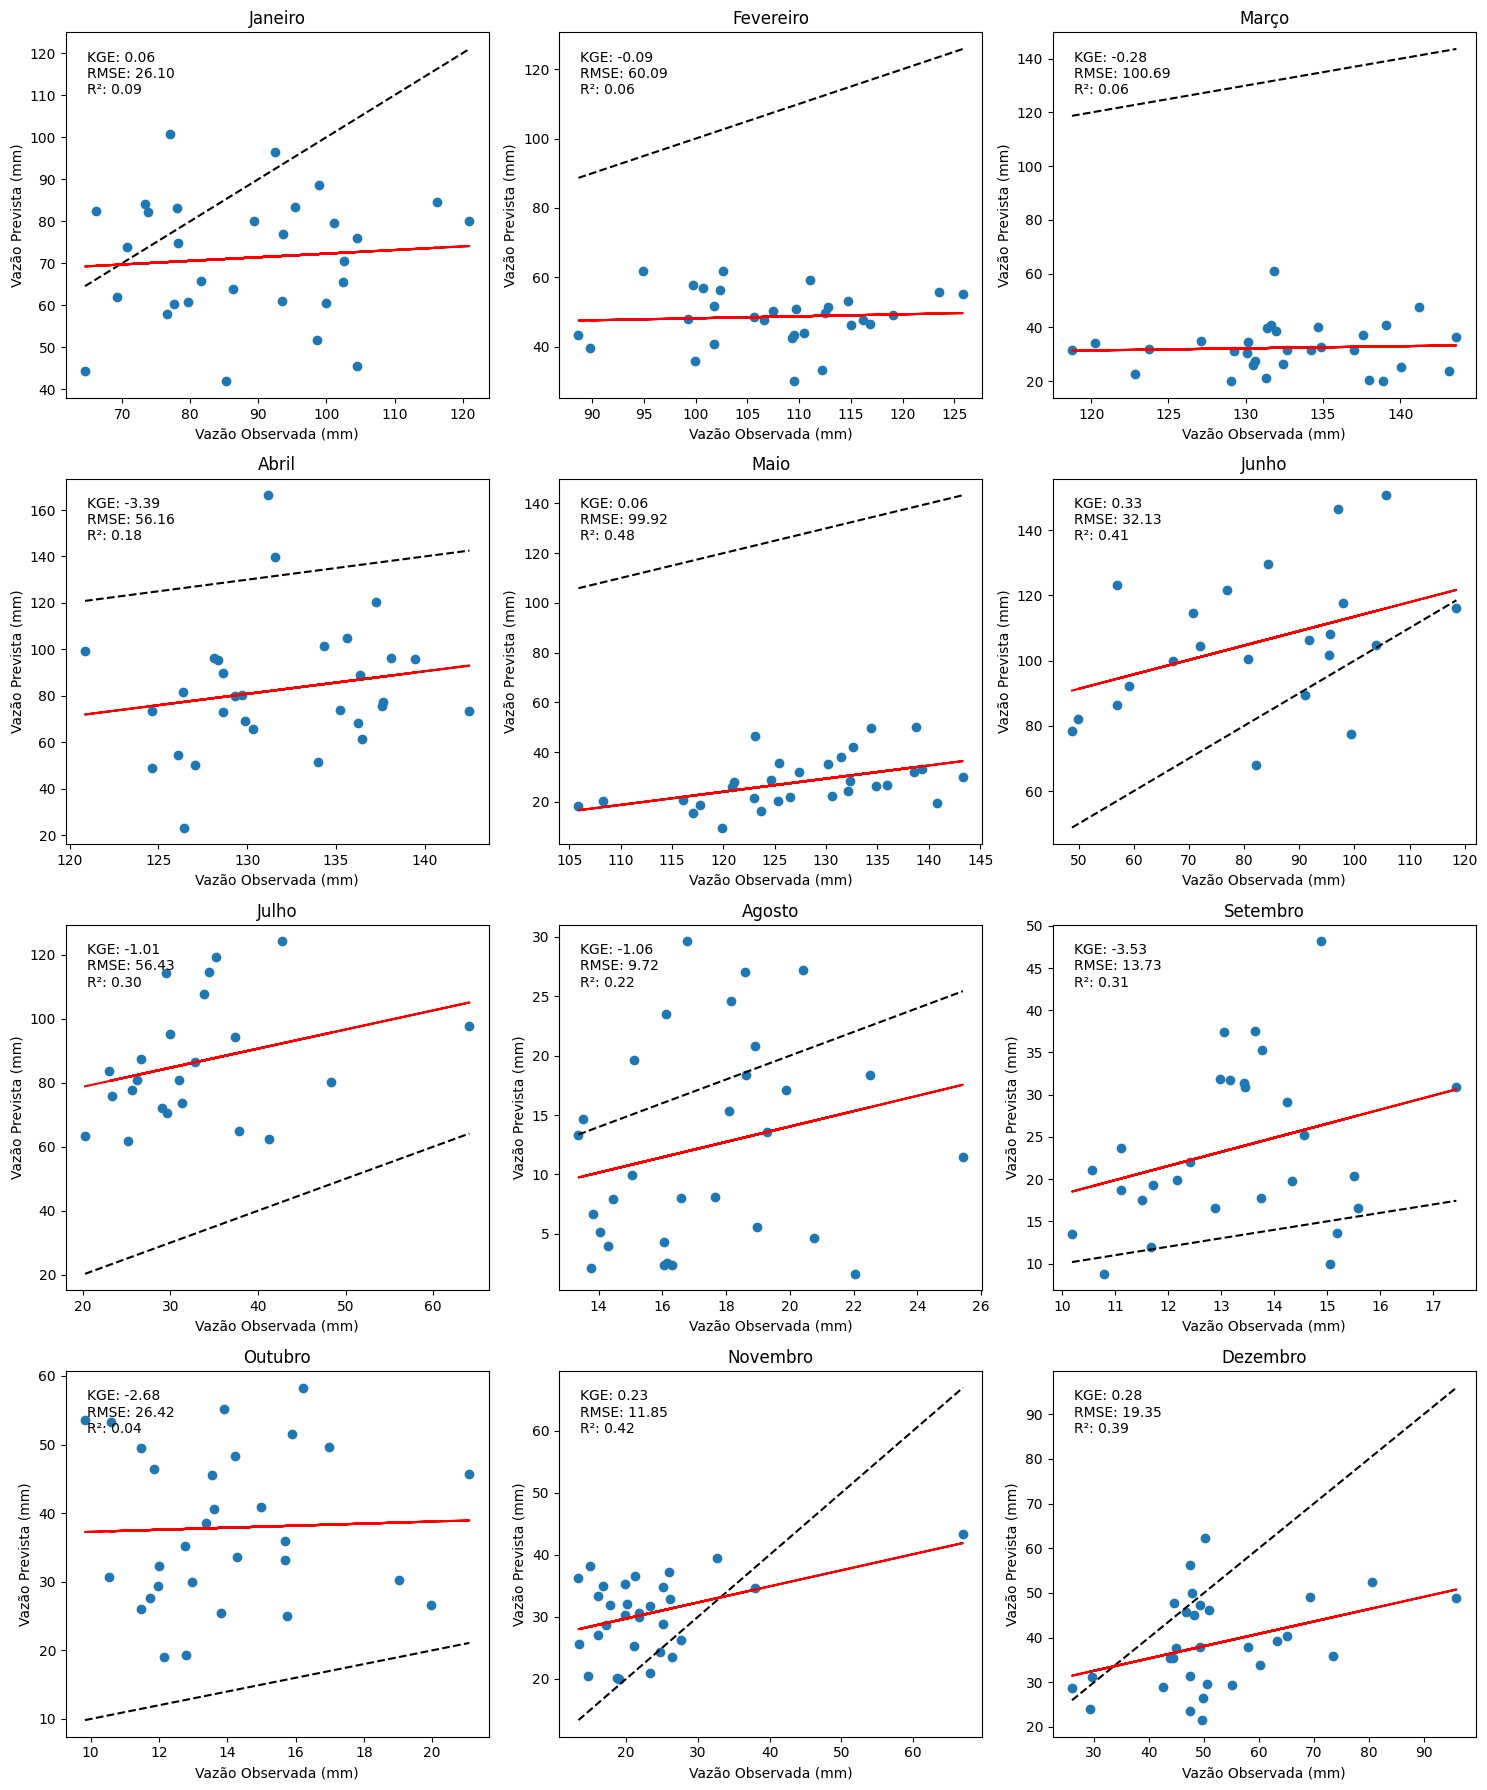

In [52]:
# prompt: plotar comparação de q e q_pred de todos os meses, com 3 colunas e 4 linhas de plot, do dataframe bacia_mes

import matplotlib.pyplot as plt

# Número de linhas e colunas para a grade de plots
n_rows = 4
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 18))  # Ajuste o tamanho conforme necessário

# Iterar pelos meses e criar os plots
for i, month in enumerate(range(1, 13)):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    # Filtrar dados para o mês atual
    month_data = bacia_mes[bacia_mes['Month'] == month]

    # Obter o nome do mês da coluna 'month_name' do DataFrame bacia_mes
    month_name = bacia_mes.loc[bacia_mes['Month'] == month, 'month_name'].iloc[0]

    # Calcular R², KGE e RMSE
    kge_result = kge(month_data['q_pred'], month_data['q'])
    rmse = np.sqrt(np.mean((month_data['q_pred'] - month_data['q'])**2))
    slope, intercept, r2, p_value, std_err = scipy.stats.linregress(month_data['q'], month_data['q_pred'])

    # Criar o scatter plot
    ax.scatter(month_data['q'], month_data['q_pred'], label = month_name)

    # Ajustar a linha de tendência
    x = month_data['q'].values.reshape(-1, 1)
    y = month_data['q_pred'].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x, y)
    # Previsões da linha de tendência
    y_pred = model.predict(x)

    # Adicionar linha de referência 1:1 e linha de tendencia
    ax.plot([min(month_data['q']), max(month_data['q'])], [min(month_data['q']), max(month_data['q'])], color='black', linestyle='--')
    ax.plot(x, y_pred, color='red', label=f'Tendência (R² = {r2:.2f}) \n y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f}')

    # Configurar o título, texto e os rótulos dos eixos
    ax.set_title(month_name)
    ax.set_xlabel('Vazão Observada (mm)')
    ax.set_ylabel('Vazão Prevista (mm)')
    ax.text(0.05, 0.95, f'KGE: {kge_result:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar os plots
plt.show()